In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [31]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [33]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [34]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Daniel Yoon\AppData\Local\Temp\ipykernel_11364\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [35]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [36]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()

print(recent_date)

2017-08-23


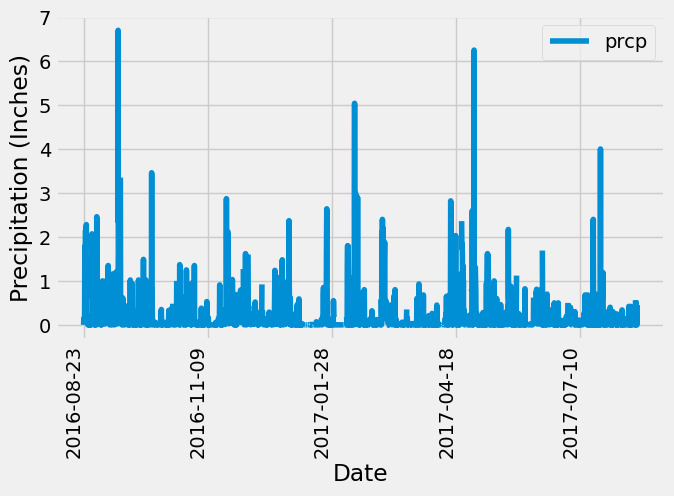

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = (dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days = 365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
query = "SELECT date, prcp FROM measurement WHERE date >= '2016-08-23' order by date;"

# Save the query results as a Pandas DataFrame. Explicitly set the column names
conn = engine.connect()
df = pd.read_sql(query, conn).set_index('date')

# Sort the dataframe by date
df = df.sort_values('date')
df

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(7,4))
plt.ylabel('Precipitation (Inches)')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Station).count()
stations

9

In [46]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(desc(func.count(Measurement.station))) \
    .all()


# List the stations and their counts in descending order.
for item in active:
    print(item)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
calculations = session.query(
    Measurement.station,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == 'USC00519281').all()
                    
print(f"Most active station = ({calculations[0][0]}) \n Lowest temperature = {calculations[0][1]}, \n Highest temperature = {calculations[0][2]}, \n Average temperature = {round(calculations[0][3], 2)}")


Most active station = (USC00519281) 
 Lowest temperature = 54.0, 
 Highest temperature = 85.0, 
 Average temperature = 71.66


Text(0, 0.5, 'Frequency')

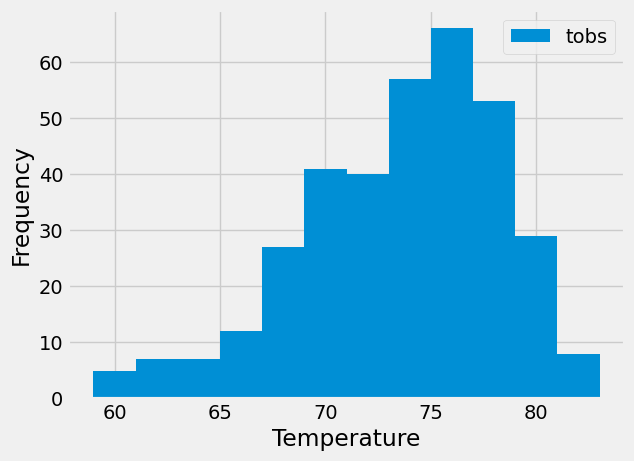

In [69]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Queries the database
temperature = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.station == 'USC00519281', Measurement.date >= one_year) \
    .order_by(Measurement.date) \
    .all()
# Loads the query into a DataFrame
df = pd.DataFrame(temperature).set_index('date')

df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Close Session

In [70]:
# Close Session
session.close()